In [2]:
import time

In [3]:
notebook_start = time.time()

In [5]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Multivariate Time Series Analysis and Prediction with TensorFlow #

Will be using the weather time series dataset recorded by the Max Plank Institute for Biogeochemistry, which contains 14 different features such as air temperature, atmospheric pressure, and humidty.  Data was collected every 10 minutes from 2009-2016.

# Data Preprocessing #

Let's start by loading in the data from the public source and creating our initial dataframe.

In [6]:
# Data was prepared by Francois Chollet for his book, Deep Learning with Python
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 21s 2us/step


In [7]:
# We will be forecasting for hourly predictions, so subsample to 1 hour intervals
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record. (because each record is a 10 minute interval)
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

## Exploratory Data Analysis ##

In [8]:
# show the results
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70091 entries, 5 to 420545
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p (mbar)         70091 non-null  float64
 1   T (degC)         70091 non-null  float64
 2   Tpot (K)         70091 non-null  float64
 3   Tdew (degC)      70091 non-null  float64
 4   rh (%)           70091 non-null  float64
 5   VPmax (mbar)     70091 non-null  float64
 6   VPact (mbar)     70091 non-null  float64
 7   VPdef (mbar)     70091 non-null  float64
 8   sh (g/kg)        70091 non-null  float64
 9   H2OC (mmol/mol)  70091 non-null  float64
 10  rho (g/m**3)     70091 non-null  float64
 11  wv (m/s)         70091 non-null  float64
 12  max. wv (m/s)    70091 non-null  float64
 13  wd (deg)         70091 non-null  float64
dtypes: float64(14)
memory usage: 7.5 MB


In [10]:
df.isnull().mean()

p (mbar)           0.0
T (degC)           0.0
Tpot (K)           0.0
Tdew (degC)        0.0
rh (%)             0.0
VPmax (mbar)       0.0
VPact (mbar)       0.0
VPdef (mbar)       0.0
sh (g/kg)          0.0
H2OC (mmol/mol)    0.0
rho (g/m**3)       0.0
wv (m/s)           0.0
max. wv (m/s)      0.0
wd (deg)           0.0
dtype: float64

Okay great, the data is now loaded in as a dataframe and appears to be a nice, clean dataset with no missing values.  Let's take a look.

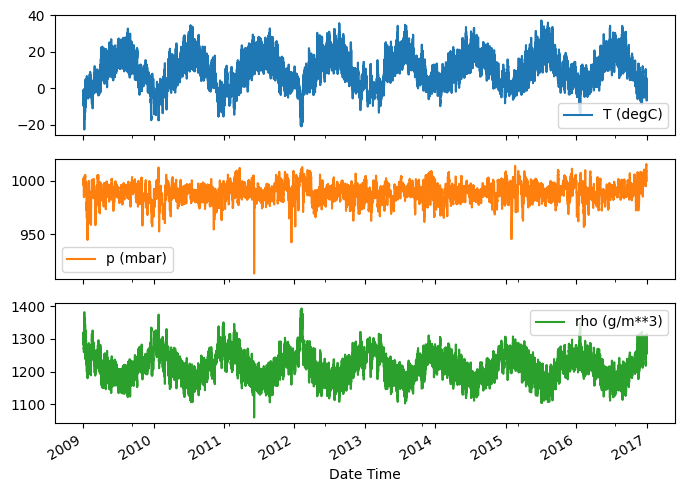

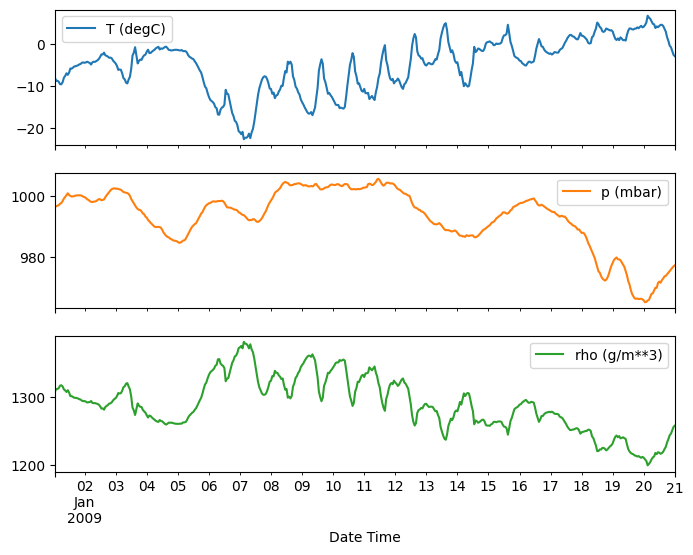

In [11]:
# Visualize Temperature, Pressure, and Humidity over Time
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

# Zoom in on the month of January 2009
plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
a_ = plot_features.plot(subplots=True)

Okay great, this should be a fun dataset to work with.  We can see some clear seasonality in the data, and plenty of noise to sort through.  Additionally, when you zoom in on the noisy data you can see clear trends as the seasons progress.

In [12]:
# Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


Everything looks good, except for the wv and max. wv columns have a minimum value of -9999.00 which looks like an error.  Additionally, given the wind direction wd the velocity should always be positive.  We will replace that erroneous value with 0s.

In [13]:
# Filter the df to all the erroneous values and set them to 0
wv = df['wv (m/s)']
bad_wv = wv == -9999.00
wv[bad_wv] = 0.0

# Repeat with max wv
max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# Check the results compared to the descriptive summary before
df['wv (m/s)'].min()

0.0

## Feature Engineering ##

Although the data appears nice and clean, it is not perfectly suited for modeling yet.  We will need to do some feature engineering to prepare the df for deep learning.

First we will vectorize the wind direction and velocity columns.  

In [14]:
# Remove the degree column temporarily for conversion
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert degrees to radians
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind components and add to df
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind components and add to df
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

Now the date and time is very valuable, but not in its current state.

First convert the string to a timestamp.

In [15]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Now to capture the cyclical features of 24 hour time, we can use sine and cosine signals.  This will encode the natural day and night cycle in daily data and flow of the seasons in yearly.

Although we are familiar with this frequency in weather data, it may not always be so obvious.  We can take a look at the signal fft and find the peaks at the appropriate times.

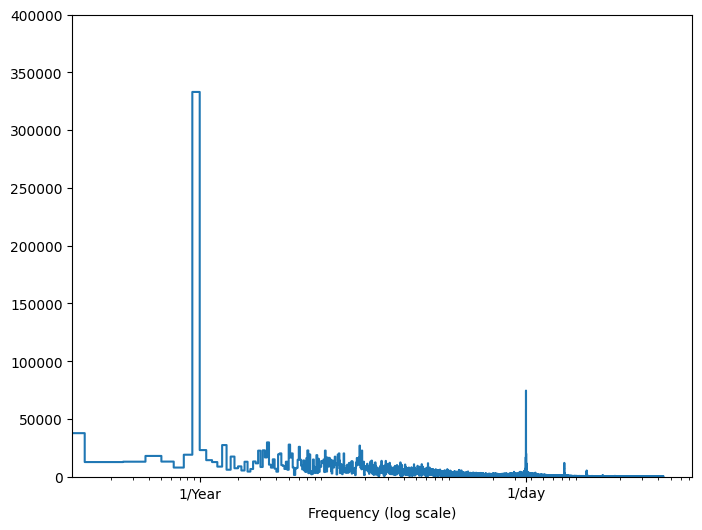

In [16]:
# utilizing tf.signal.rfft to find the frequency peaks
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

As expected, we see clear peaks at a the year and day frequency intervals.  We will encode these now.

In [17]:
day = 24*60*60
year = 365.25*day

# sin and cos signals
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

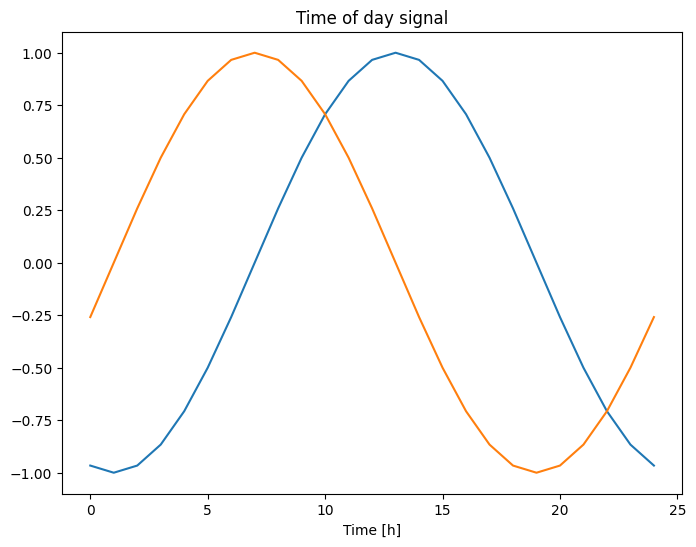

In [18]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

### Train, Test, Validation Split ##

We will use a 70%/20%/10% Train/Test/Validation split 

Note the data is **not** being randomly shuffled as is typical.  This is because we are very interested in the sequencing of the events as it is time series data.  An example is shown below.

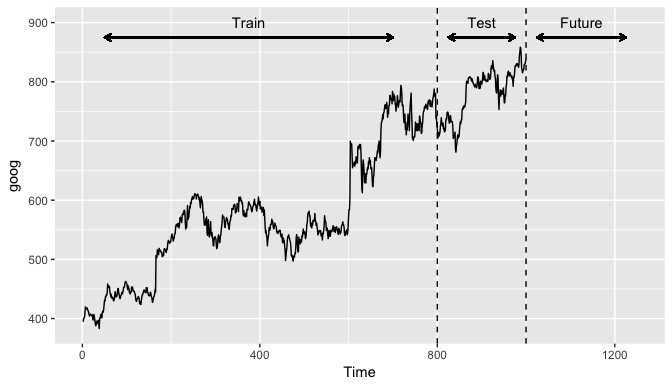

In [20]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

## Normalization ##

A key component of data preprocessing is scaling the features.  Looking back at the descriptive statistics, the pressure data is multiple orders of magnitude greater than the wind data for example.  Normalizing the data is critical.

We do this by normalizing to the mean of each column.  It is important to only perform this calculation on the training set to avoid information leakage into the model.  We do not want our model to know any information about the test dataset.

In [21]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

C:\Users\N.G.O\AppData\Local\Temp\ipykernel_21352\2874464267.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


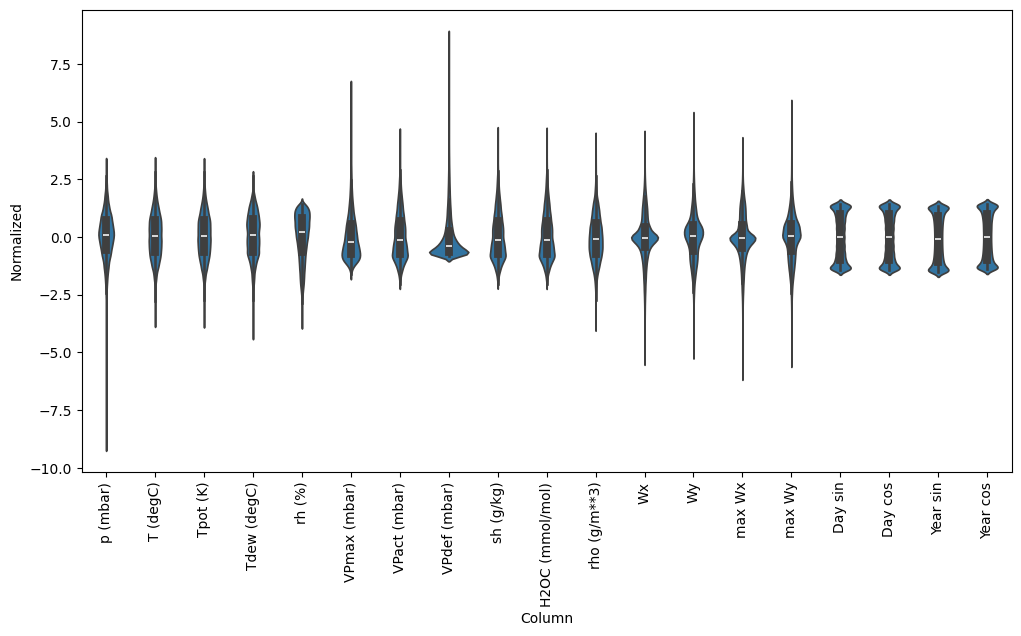

In [22]:
# Visualize scaled columns
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

Okay great.  Although a few columns still have noticeable tails, the outliers have all been removed and the dataset is normalized for modeling.

## Data Windowing ##

Next up is windowing the data, or grouping it into time intervals for prediction.  For example, we may build our model to predict the next hour of data based on the previous 24 hours using a RNN.  An example of windowing is shown below.

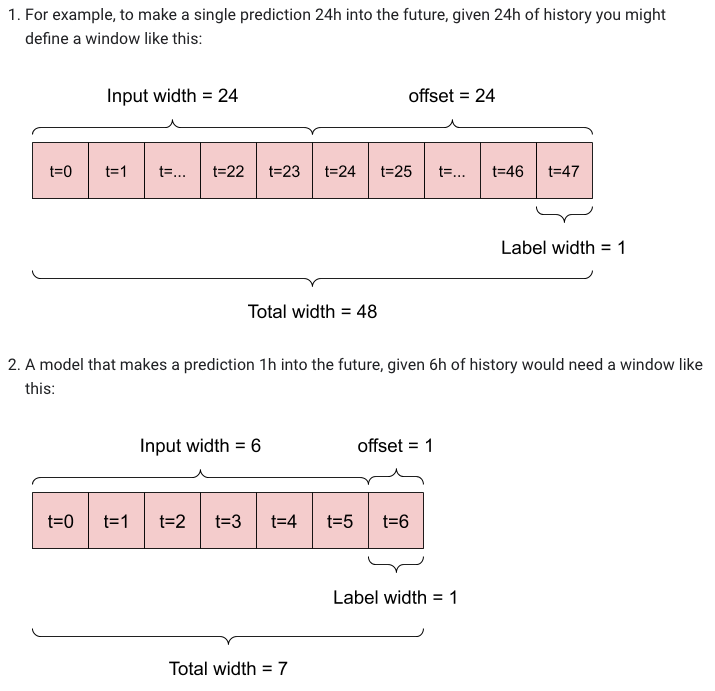

In [25]:
# Set up window generator class
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [26]:
# Set up window from example
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [27]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

From there we need to split the window into inputs and labels.

In [28]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [30]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


In [31]:
# Plot a simplified visualzation of split window
w2.example = example_inputs, example_labels

In [32]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

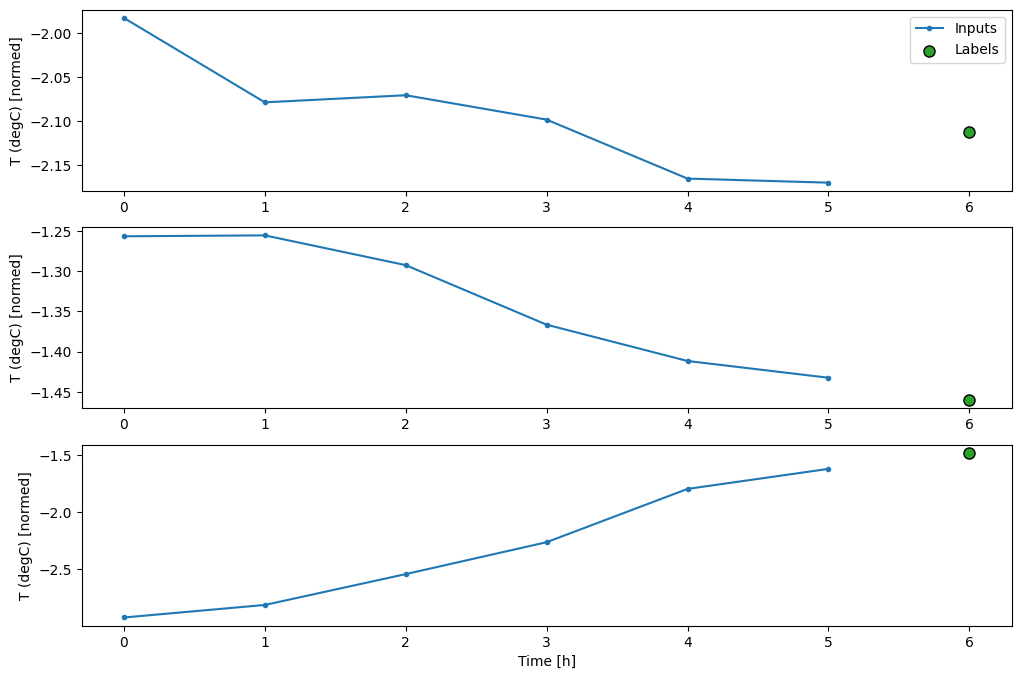

In [33]:
w2.plot()

So the way this will be used, the inputs will be used to make a prediction that will be compared against the label to evaluate performance.

And of course, we are only predicting the Temperature and the other columns do not have the label.

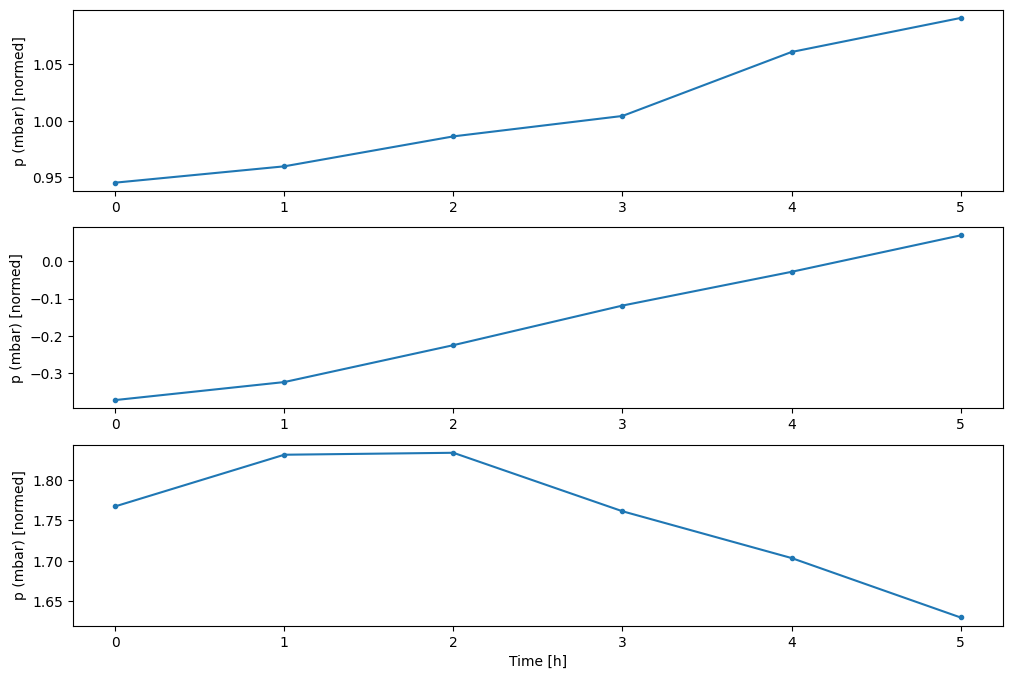

In [34]:
w2.plot(plot_col='p (mbar)')

For the final preprocessing step we will be creating the make_datasets method to take a time series dataframe and convert it to a tf.data.Dataset of input windows and label windows.

In [35]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [36]:
# Add properties to access train, validation and test sets
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [37]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Perfect, we now have it set up to easily iterate over our dataset.

In [38]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


Okay great, we have our preprocessing steps done and our window generator class ready to be reused for various model structures.

# Single Time Step Predictions #

To begin, we will start by building models that predict 1 hr into the future.

## Single Output Models ##

Beyond that, we will also start with a very simple approach only predicting an individual feature, in this instance Temperature.

### Baseline ###

Let's start with a super simple, almost blind model using the previous days temperature for the prediction.  This will provide a good baseline and we should be able to see significant improvements with more complex models.

In [39]:
# Configure the window generator to produce a single step
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=['T (degC)'])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [40]:
# Define baseline
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [41]:
# Instantiate and evalute baseline
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])
# Create dictionaries to store performance of various models to plot later
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 1s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


In [42]:
# Create a wider window to view the results. 
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

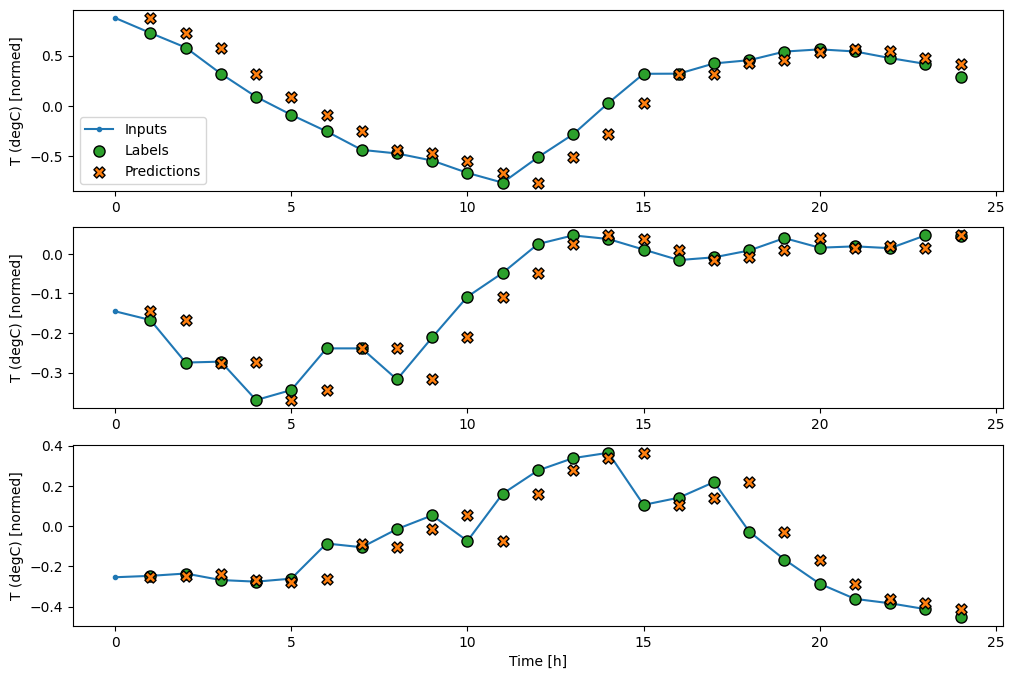

In [43]:
wide_window.plot(baseline)

Okay, a baseline model!  It is simply predicting the label from the previous day, but that "dumb" approach can be fairly accurate as the temperature tends to shift slowly over a period of multiple days, as opposed to massive shifts overnight.  But we can do much, much better than this!

### Linear ###

Let's take a look at a simple Linear model.  Think of it like drawing a line of best fit and through a certain time interval and using it to predict the next hour of data.  One benefit of using this for our baseline is linear models can be evaluated to gain some insight into which features are the strongest predictors, which is a very common question received from project stakeholders.

In [44]:
# create a simple linear model, a single dense layer with no activation set
linear = tf.keras.Sequential([
                              tf.keras.layers.Dense(units=1)
])

#### Modular Code Setup ####

Like always, let's set up some modular code to make running and comparing various models more streamlined

In [45]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  # early stopping is a great feature that will end training if there is no gains being made
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  # Compile the model using the Adam optimizer and MAE for evaluations
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
  # Fit the model and store results
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [46]:
# This function will compile and fit the model and show the results
def show_results(model_name, model, step_window,val_dict, perf_dict):
  start = time.time()
  history = compile_and_fit(model,step_window)
  IPython.display.clear_output()
  val_dict[model_name] = model.evaluate(step_window.val)
  perf_dict[model_name] = model.evaluate(step_window.test, verbose=0)
  end = time.time()
  seconds = end-start
  minutes = seconds / 60
  print(f'>> Runtime: {seconds:.2f} seconds ({minutes:.2f} minutes)')

In [47]:
# Utilize the modular code to train, fit, and show results of linear model
show_results('Linear',linear,single_step_window, val_performance, performance)

439/439 [==============================] - 1s 2ms/step - loss: 0.0087 - mean_absolute_error: 0.0692
>> Runtime: 25.97 seconds (0.43 minutes)


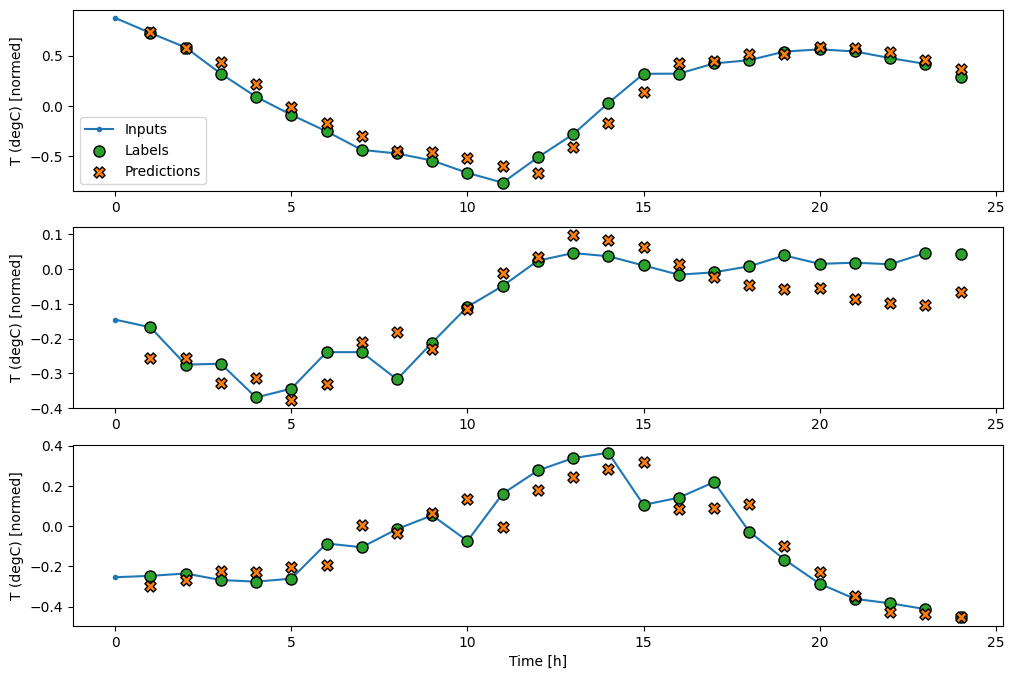

In [48]:
# plot the results using that wide window view
wide_window.plot(linear)

Okay great, that is a decent start for our first simple machine learning model, and it does appear to have a slightly tighter fit.

Additionally, as mentioned the linear model has the added bonus of interpretability.  Let's examine the features a little closer to see their weights.

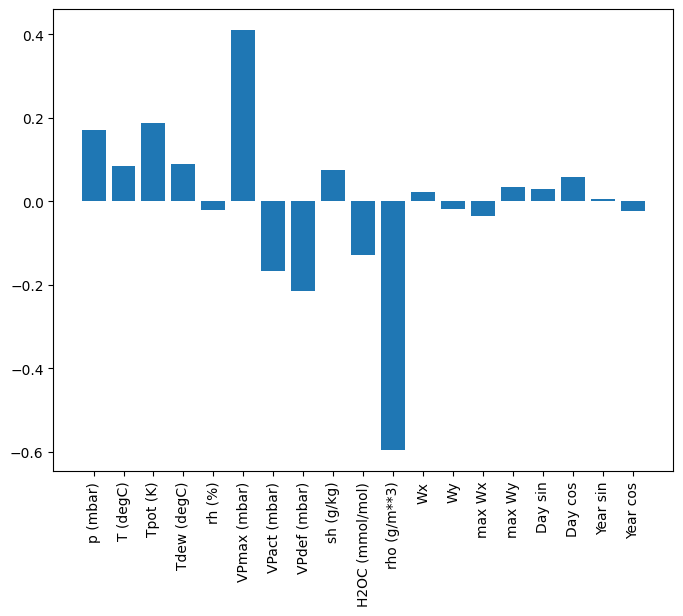

In [49]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### Simple Deep Learning Model ###

We can also add a couple of Dense layers to increase the learning capacity of the model.  Let's see how a simple neural network performs.

In [50]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

show_results('Dense',dense,single_step_window,val_performance,performance)

439/439 [==============================] - 1s 2ms/step - loss: 0.0069 - mean_absolute_error: 0.0599
>> Runtime: 39.77 seconds (0.66 minutes)


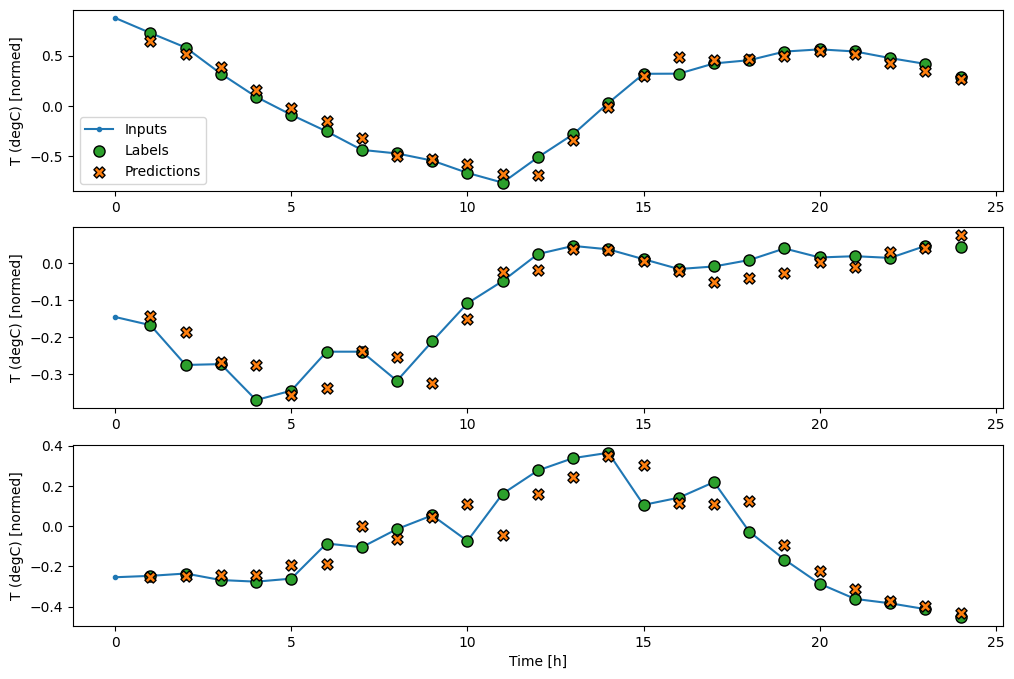

In [51]:
wide_window.plot(dense)

Okay great, that looks pretty decent for a single step, relatively simple deep learning model.  But remember this is a time series, and that sequence of time and the historical trend can be very powerful information for forecasting.

### Multi-Step Deep Learning ###

We can implement multi-step models to learn how these features are changing over time.  This will learn more detail of the cyclical nature of the day/night and seasonality.  

In [52]:
# Create convolutional window of chosen width
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)']
)

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

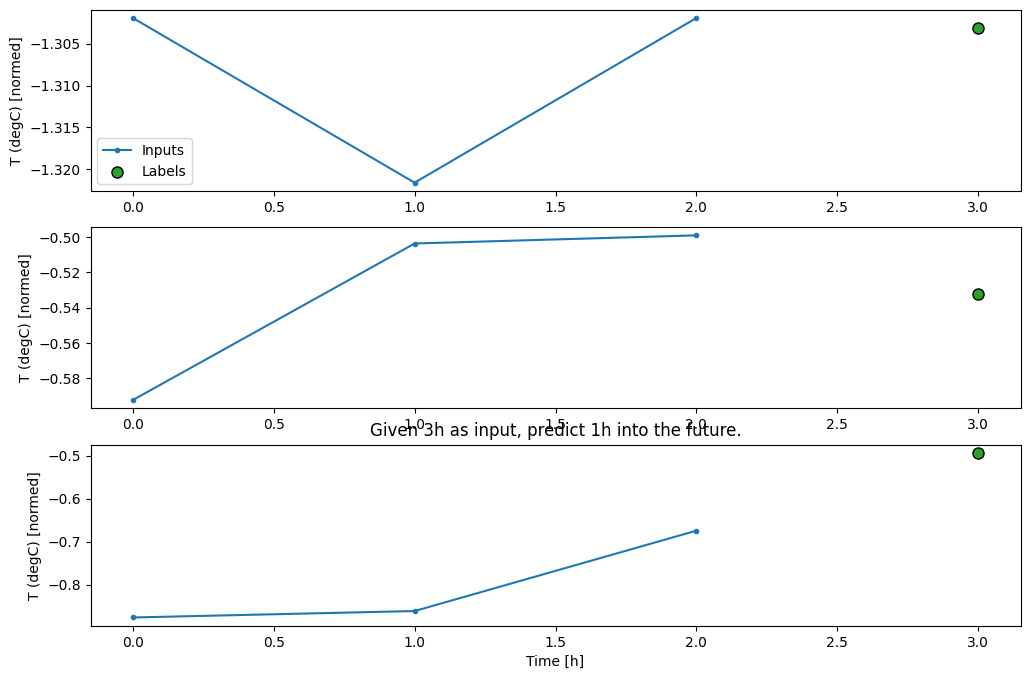

In [53]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

In [54]:
# Create CNN to handle input of any length
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

show_results('CNN', conv_model, conv_window,val_performance,performance)

438/438 [==============================] - 1s 2ms/step - loss: 0.0065 - mean_absolute_error: 0.0579
>> Runtime: 54.29 seconds (0.90 minutes)


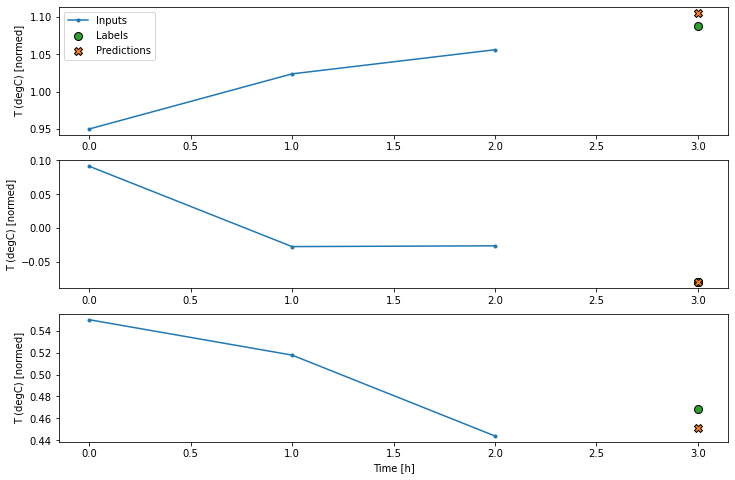

In [49]:
conv_window.plot(conv_model)

Now let's make a window window for plotting like before, but this time a wide convolutional window

In [50]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

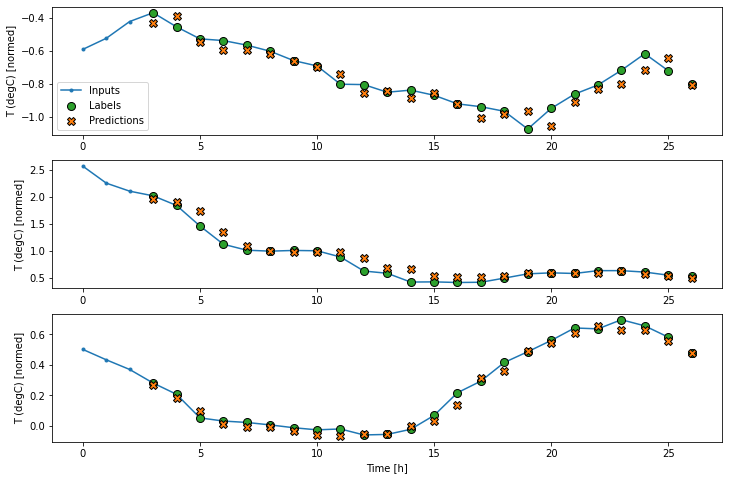

In [51]:
wide_conv_window.plot(conv_model)

### Long Short Term Memory Recurrent Neural Network ###

Or more commonly referred to as an LSTM, a version of RNN.  We have played around with LSTMs extensively in previous NLP projects, but if you have skipped that a brief overview.

RNNs have the capacity to pass knowledge through the model, making it particularly well suited for problems where input sequence is key (NLP, speech recognition, and of course Time Series Forecasting)

Let's utilize an LSTM that is set to train on 24 hours of data at a time.

In [52]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

show_results('LSTM', lstm_model, wide_window,val_performance,performance)

438/438 [==============================] - 2s 4ms/step - loss: 0.0056 - mean_absolute_error: 0.0519
>> Runtime: 147.32 seconds (2.46 minutes)


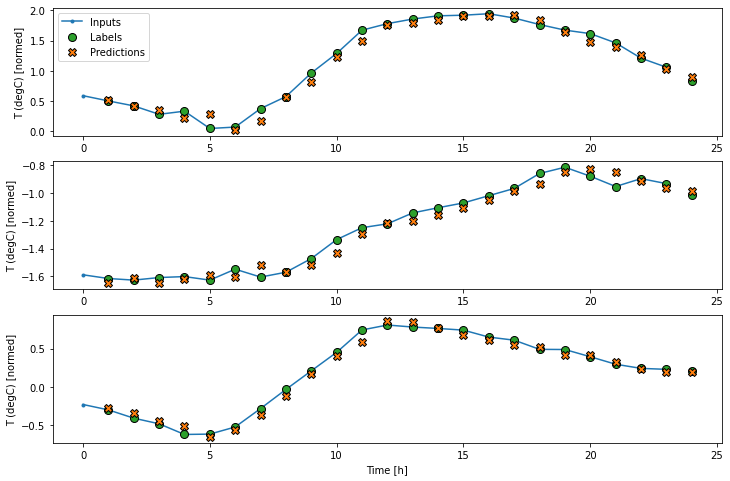

In [53]:
wide_window.plot(lstm_model)

Let's take a look and see how these models have been performing against each other.

We have been progressively using more complex and purpose-built approaches, so we should see steady improvement.

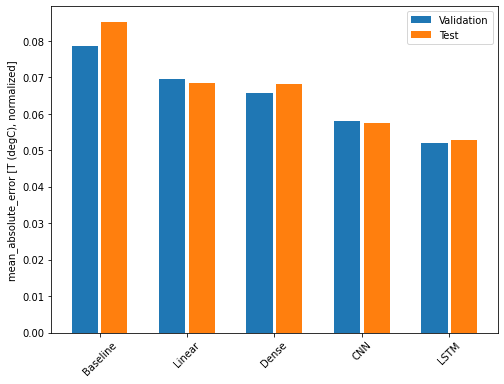

In [54]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [55]:
# MAE for each model
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0683
Dense       : 0.0681
CNN         : 0.0575
LSTM        : 0.0527


## Multi-Output Models ##

To this point we have been building models to make a single prediction for the temperature in the next hour.  Although this can be useful, we can really push this model even further and predict the value for every feature in the dataset!

This is called a multi-output model and it is relatively simple to convert our single-output structures.  Let's go through each one now.

In [56]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


In [57]:
# Baseline 
# MAE will be an average of the errors for each prediction
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [58]:
# Reset the performance dictionaries for storing results
val_performance = {}
performance = {}

In [59]:
# Start with the baseline again
show_results('Baseline', baseline, wide_window,val_performance,performance)

438/438 [==============================] - 2s 3ms/step - loss: 0.0886 - mean_absolute_error: 0.1589
>> Runtime: 33.51 seconds (0.56 minutes)


In [60]:
# Simple deep learning network
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

show_results('Dense',dense,single_step_window,val_performance,performance)

439/439 [==============================] - 2s 4ms/step - loss: 0.0682 - mean_absolute_error: 0.1320
>> Runtime: 125.63 seconds (2.09 minutes)


In [61]:
# LSTM
# Set up wide window for multi-output
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

# Define LSTM model
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

show_results('LSTM',lstm_model,wide_window,val_performance,performance)

438/438 [==============================] - 2s 4ms/step - loss: 0.0616 - mean_absolute_error: 0.1206
>> Runtime: 189.56 seconds (3.16 minutes)


### ResNets ###

Our models have been attempting to predict the actual values for each feature, but it is actually more powerful to simply predict the rate of change of the features.

"It's all relative" is a phrase I like to use, but it does apply here.  As we know weather changes progressively, we can use this information in our models to improve performance.  This is called **Residual Connections** and is even more powerful than a straightforward LSTM.  ResNets have gained a lot of popularity recently due to this capability. 

Let's build a Residual LSTM now.  In our NLP project we used the ktrain wrapper, for this one we will build our own residual wrapper.

In [62]:
# Build the wrapper
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [63]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros())
]))

show_results('Residual LSTM', residual_lstm, wide_window,val_performance,performance)

438/438 [==============================] - 2s 4ms/step - loss: 0.0620 - mean_absolute_error: 0.1181
>> Runtime: 117.82 seconds (1.96 minutes)


Like we did with our single-output models, let's compare the results now.  Similarly to before, we should see a progressive improvement as we added more advanced features tailored to this problem space.

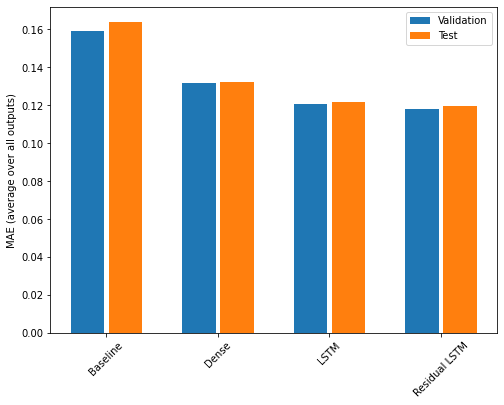

In [64]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [65]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1321
LSTM           : 0.1217
Residual LSTM  : 0.1196


Awesome!

But we can really do much more.  To this point we have only predicted values 1 hour into the future.  This type of nearterm predictive power can have useful applications, but it is much more useful to predict values over an extended time interval into the future.

This is called a multi-step model, let's dive into that now.

# Multi-Step, Multi-Output Predictions #

We will now create a model to predict the hourly weather data for the next 24 hour interval.  This can be done in two distinct ways.

1. **Single-Shot** where the entire time interval is predicted at once
2. **Autoregressive** model predicts a single step at a time, progressively using that prediction as input for the next hour.

In addition to predicting the multiple time steps, we will also continue with the multi-output models predicting all of the features.

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

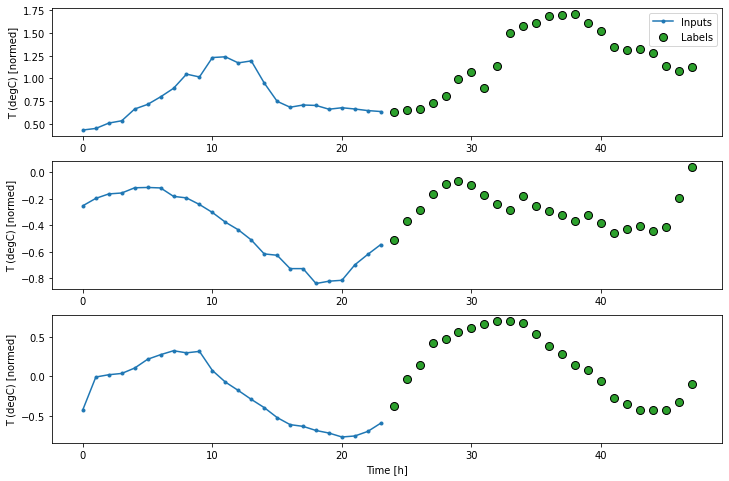

In [66]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

## Baseline ##

Once again, let's start with a simple baseline model.  Before, we simple used the previous hour label to predict the next hour.  This is okay, but given the day/night cyclical nature of the dataset it wouldn't make as much sense to just use the last value as the predicted value for the next 24 hours given the constant fluctuation of weather data.

What we can do, is simply tell the model to repeat the 24 hour interval.  This would mean the weather did not change from day to day, but maintained the changes it experienced within that individual cycle. The process is illustrated below.

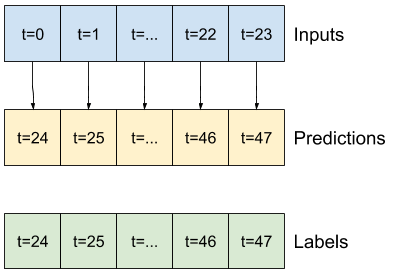

437/437 [==============================] - 2s 4ms/step - loss: 0.4270 - mean_absolute_error: 0.3959
>> Runtime: 67.16 seconds (1.12 minutes)


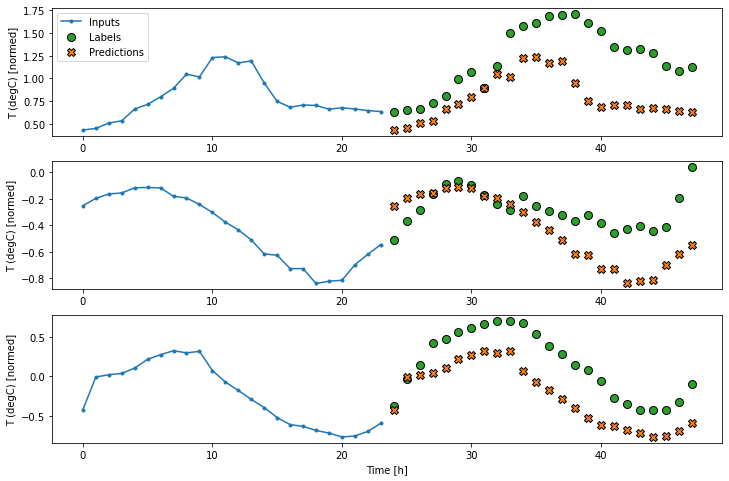

In [67]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

# Create dictionaries to compare performance
multi_val_performance = {}
multi_performance = {}

# From the top!
show_results('Baseline',repeat_baseline,multi_window,multi_val_performance,multi_performance)
multi_window.plot(repeat_baseline)

## Single-Shot Models ##

As mentioned before, a quicker approach to this problem is to perform a "single-shot" prediction, predicting the entire time interval at once.

We can implement this in various ways as we did the single output models.  We will skip over the simple linear model and simple linear model, as we now understand the improvements being made and will start with a CNN and LSTM to compare before building more advanced models.

### CNN ###

437/437 [==============================] - 2s 4ms/step - loss: 0.2146 - mean_absolute_error: 0.2810
>> Runtime: 122.96 seconds (2.05 minutes)


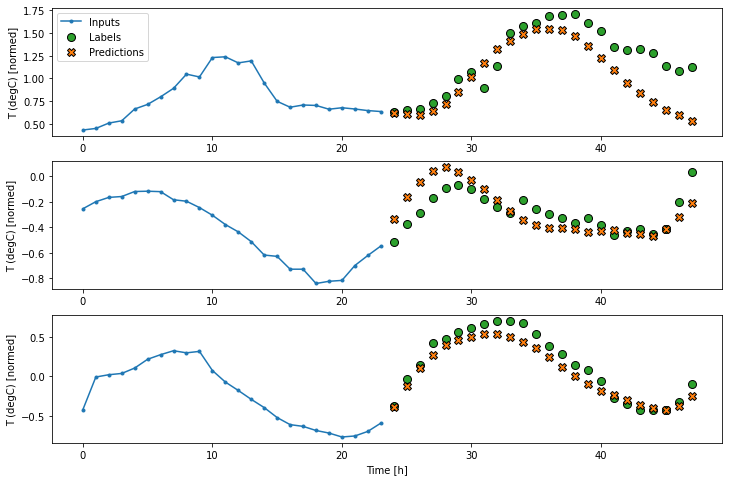

In [68]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

show_results('CNN', multi_conv_model, multi_window, multi_val_performance, multi_performance)

multi_window.plot(multi_conv_model)

### LSTM ###

437/437 [==============================] - 2s 4ms/step - loss: 0.2156 - mean_absolute_error: 0.2845
>> Runtime: 99.84 seconds (1.66 minutes)


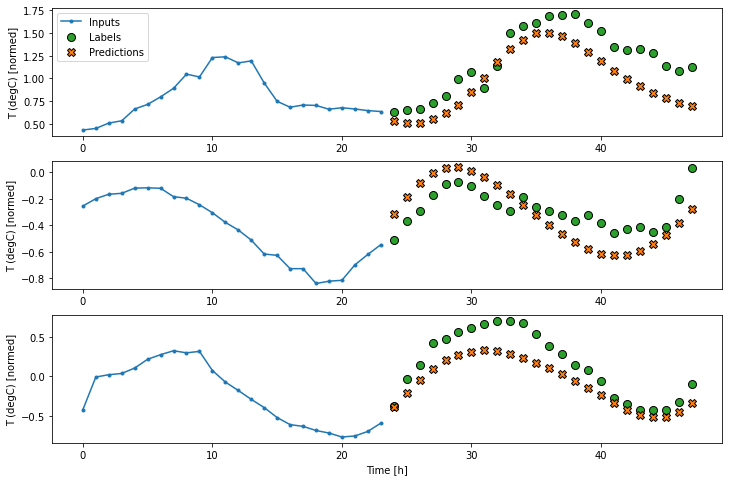

In [69]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

show_results('LSTM',multi_lstm_model,multi_window,multi_val_performance,multi_performance)

multi_window.plot(multi_lstm_model)

## Autoregressive Models ##

As mentioned, a more advanced model can use a technique called autoregression to predict each hour of data progressively, feeding the predictions back into the model as inputs.  

A huge benefit of this model structure is it can handle any output length.

The concept is a bit more complex and the code is much more verbose, but here is an illustration to describe the process.

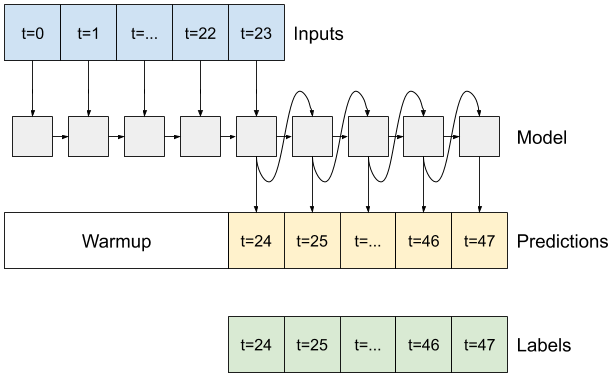

### AR LSTM ###

Will start with the same structure as the previous LSTM but add a dense layer to convert to model predictions, as well as the LSTMCell. 

Like before, we will create our own wrapper for this.

In [70]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [71]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [72]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [73]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

In [74]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

437/437 [==============================] - 4s 8ms/step - loss: 0.2219 - mean_absolute_error: 0.2950
>> Runtime: 1017.58 seconds (16.96 minutes)


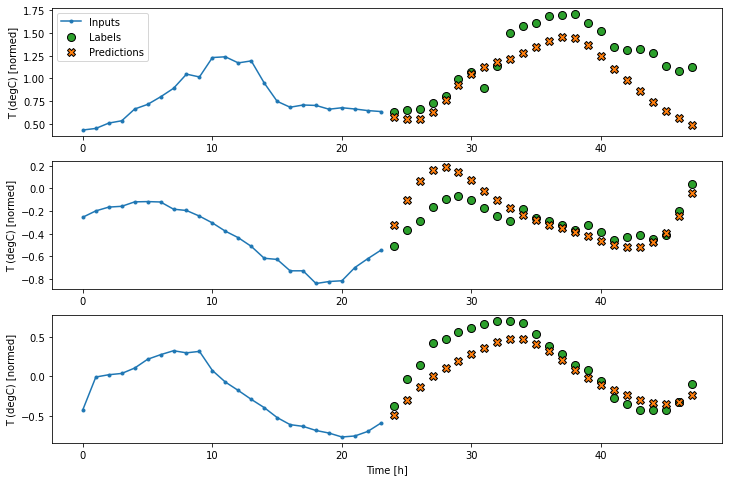

In [75]:
show_results('AR LSTM',feedback_model,multi_window,multi_val_performance,multi_performance)

multi_window.plot(feedback_model)

Once again, there is no "silver bullet" and as can be very common, there is a point of diminishing returns on complexity.  For this dataset, the more complex autoregression model actually performed worse while having a significantly increased runtime.

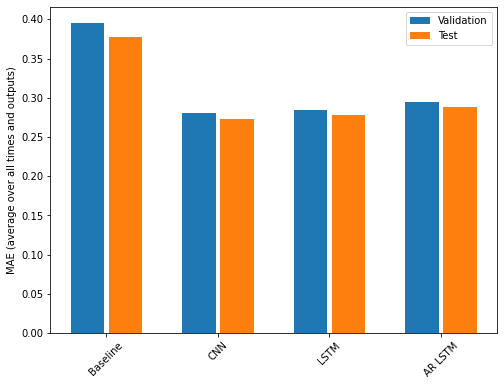

In [76]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [77]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Baseline: 0.3774
CNN     : 0.2732
LSTM    : 0.2776
AR LSTM : 0.2877


In [78]:
notebook_end = time.time()

notebook_seconds = notebook_end - notebook_start
notebook_minutes = notebook_seconds / 60
notebook_hours = notebook_minutes / 60

print(f'>> Notebook Runtime: {notebook_minutes:.2f} minutes ({notebook_hours:.2f} hours)')

>> Notebook Runtime: 35.50 minutes (0.59 hours)


This has been a great notebook going over time series analysis and forecasting in detail.  Let's put some of this to work in a practical application in the next notebook predicting future retai